In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Iridescent21
%matplotlib inline

from missense_kinase_toolkit.databases import klifs, colors

In [2]:
# generate this in databases.ipynb
df_klifs = pd.read_csv("kinhub_klifs.csv")

In [3]:
# df_klifs["group"].value_counts()
# df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: "-" in str(x))), "group"].value_counts()
# df_klifs.loc[~((df_klifs["pocket"].apply(lambda x: "-" in str(x))) | 
#               df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "group"].value_counts()
# df_klifs.loc[(df_klifs["pocket"].apply(lambda x: "-" in str(x))), "gene_name"].to_list()

list_pocket = df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "pocket"].to_list()
list_name = df_klifs.loc[~(df_klifs["pocket"].apply(lambda x: len(str(x)) != 85)), "gene_name"].to_list()

dict_pocket = {name : {idx + 1 : aa for idx, aa in enumerate(pocket)} for name, pocket in zip(list_name, list_pocket)}
df_pocket = pd.DataFrame(dict_pocket).T

In [4]:
df_pocket_melt = pd.melt(df_pocket.reset_index(), id_vars='index')
df_pocket_melt.columns = ["gene_name", "position", "amino_acid"]

In [5]:
df_pocket_pivot = df_pocket_melt.pivot_table(index="amino_acid", columns="position", values="amino_acid", aggfunc="count")
# otherwise numeric
# df_pocket_pivot.columns = [str(col) for col in df_pocket_pivot.columns]
# df_pocket_pivot.loc[df_pocket_pivot.index == "K", 17]

In [6]:
df_pocket_count = pd.DataFrame(df_pocket_melt[["position", "amino_acid"]].value_counts())
df_pocket_count = df_pocket_count.reset_index()

ALPHABET_PROJECT
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ASAP
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
RASMOL
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
SHAPELY
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
CLUSTALX
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.
ZAPPO
Invalid single-letter amino acid: -
- is an invalid amino acid; using '-' as default symbol.


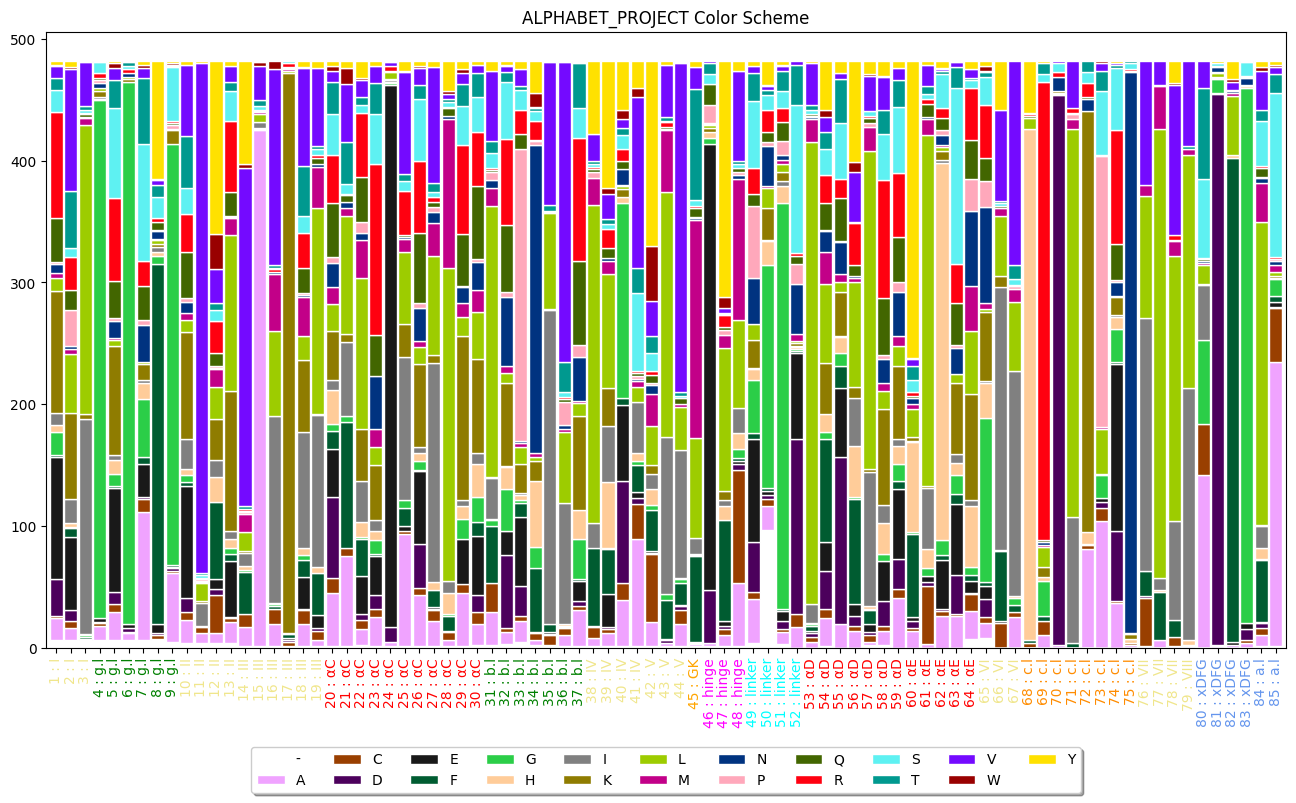

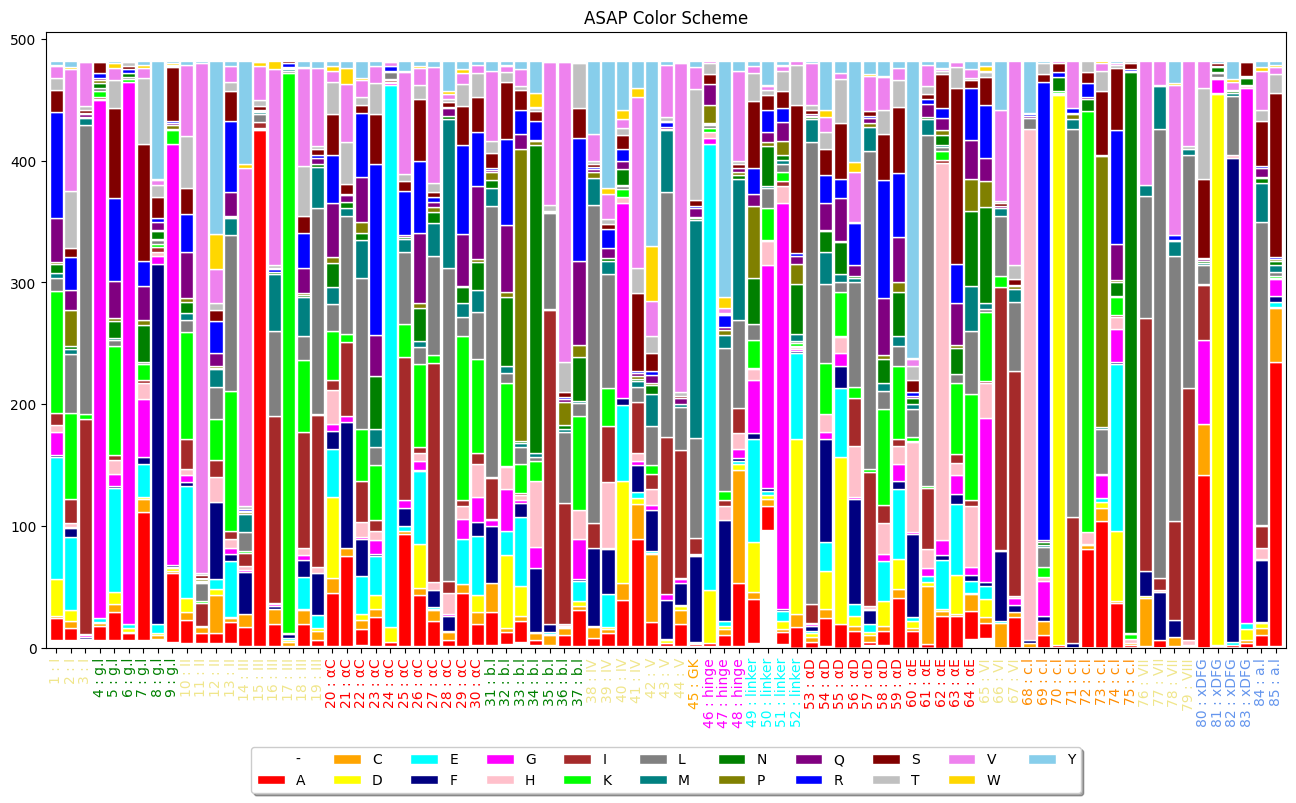

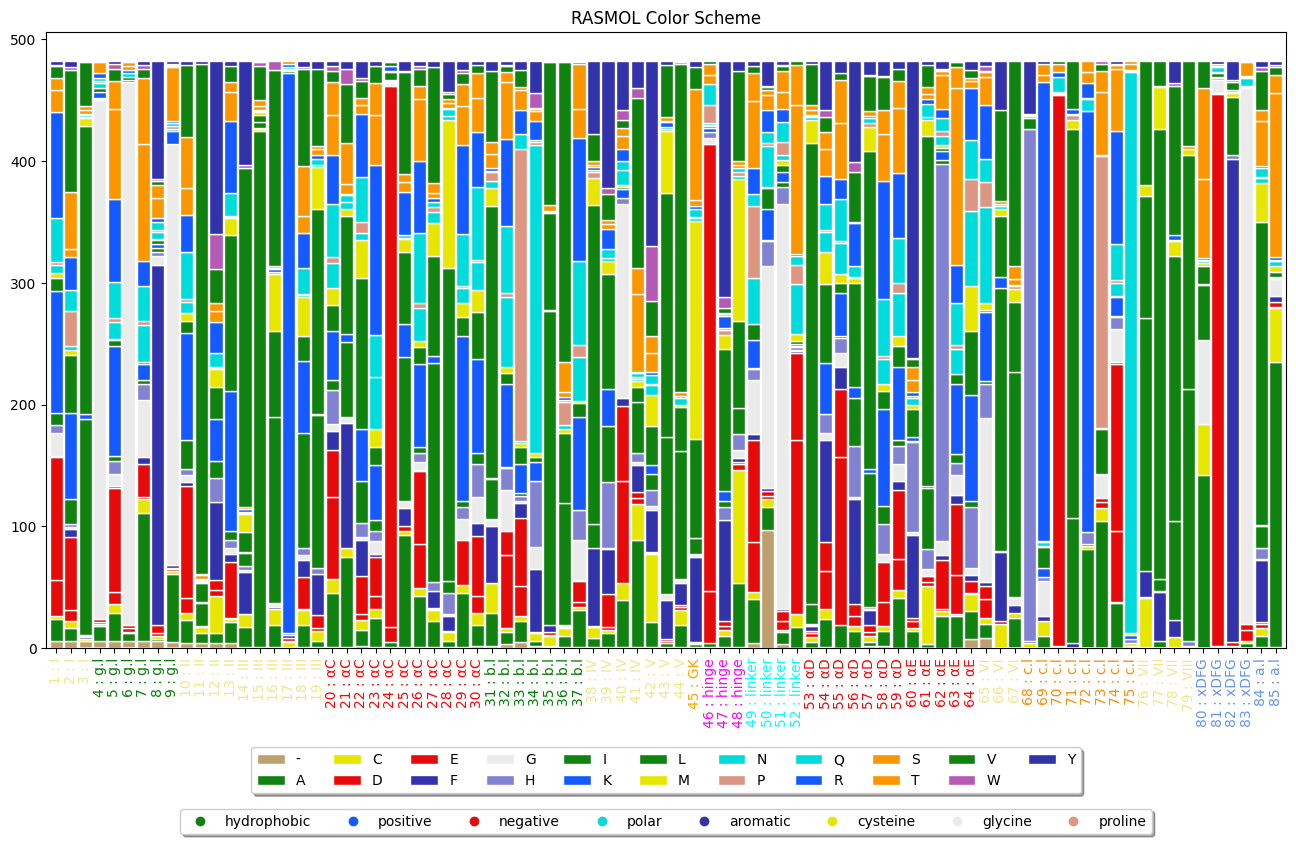

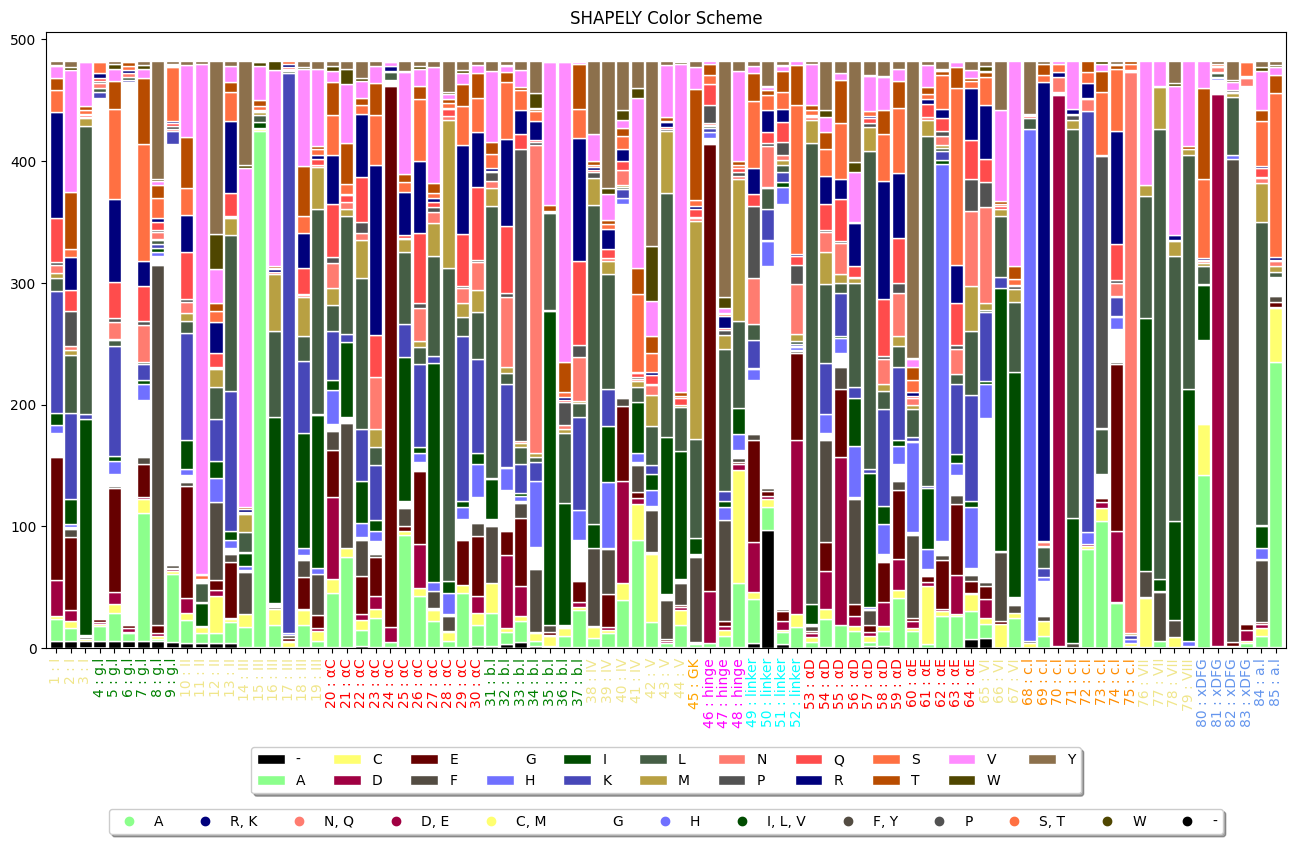

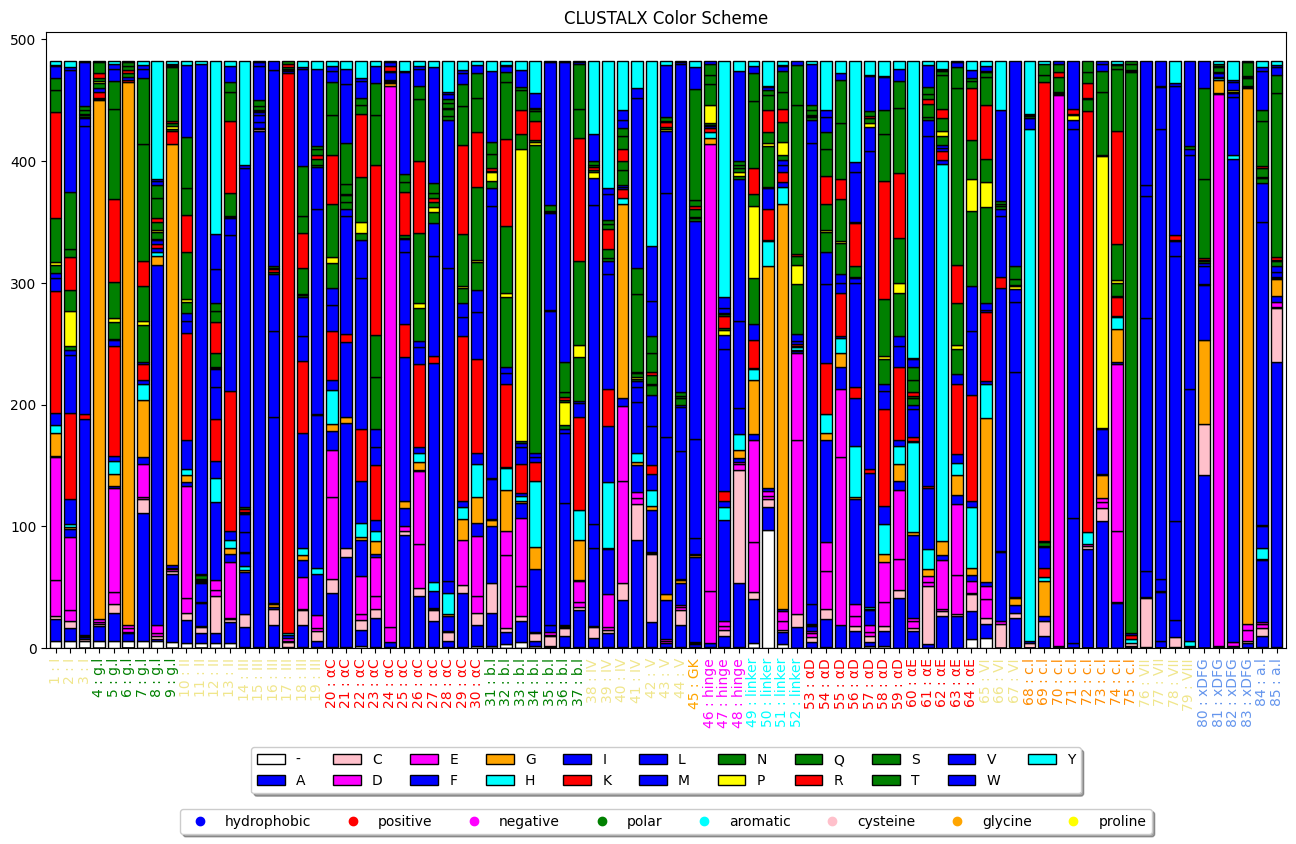

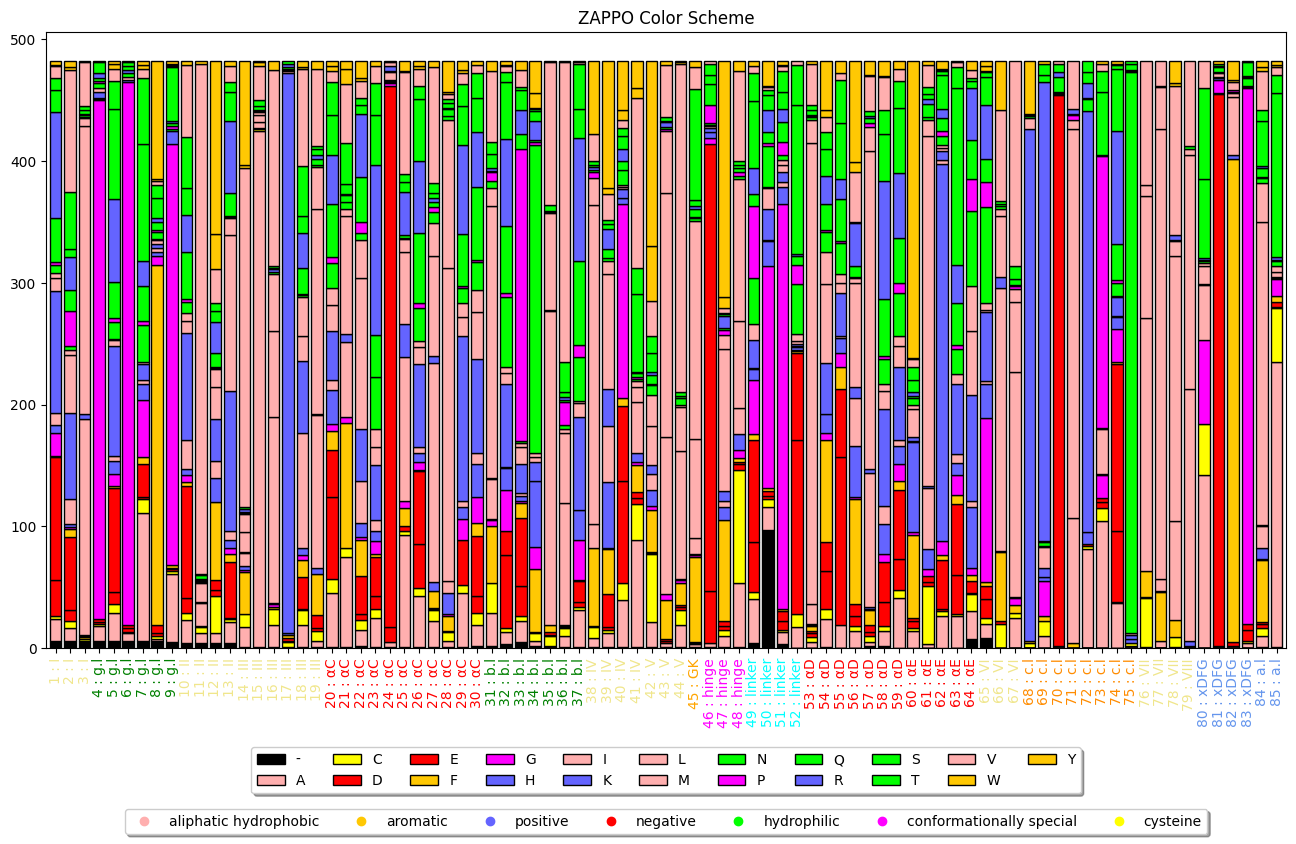

In [26]:
# change x-axis lablel to include KLIFS pocket region
df_pocket_pivot.columns = [f"{entry[0]} : {entry[1]}" for entry in klifs.POCKET_KLIFS_REGIONS]

list_cols = list(colors.DICT_COLORS.keys())
for cols in list_cols:
    print(cols)
    str_col = cols
    dict_col = colors.DICT_COLORS[str_col]["DICT_COLORS"]
    list_fill_col = [colors.map_single_letter_aa_to_color(i, dict_col) \
                     for i in df_pocket_pivot.index.tolist()]
    list_axis_col = [klifs.POCKET_KLIFS_REGION_COLORS[i[1]] for i in klifs.POCKET_KLIFS_REGIONS]
    
    if len(set(list_fill_col)) > 9:
        edgecol = "white"
        colwidth = 0.9
    else:
        edgecol = "black"
        colwidth = 0.8
    
    ax = df_pocket_pivot.T.plot(kind='bar', 
                                stacked=True, 
                                figsize=(16, 8),
                                color=list_fill_col,
                                edgecolor = edgecol, 
                                width = colwidth);
    
    for xtick, color in zip(ax.get_xticklabels(), list_axis_col):
        xtick.set_color(color)
    
    dict_annot = colors.DICT_COLORS[str_col]["DICT_ANNOTATION"]
    if dict_annot is None:
        ax.legend(loc="upper center", 
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True, 
              shadow=True, 
              ncol=11)
    else:
        l1 = ax.legend(loc="upper center", 
                       bbox_to_anchor=(0.5, -0.15),
                       fancybox=True, 
                       shadow=True, 
                       ncol=11)
        handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for _, color in dict_annot.items()]
        l2 = ax.legend(handlelist,
                       list(dict_annot.keys()),
                       loc="upper center", 
                       bbox_to_anchor=(0.5, -0.25),
                       fancybox=True, 
                       shadow=True, 
                       ncol=len(dict_annot))
        ax.add_artist(l1)
    plt.title(f"{cols} Color Scheme")
    plt.savefig(f"KLIFS_pocket_{cols}.pdf", bbox_inches="tight");